# creversiのインストール

# リバーシのDQN実装（並列版）

必要なライブラリをインポートして、リバーシのGym環境を作成します。creversiの並列版の環境を作成します。

また、PyTorchのデバイスを作成します。

In [1]:
import gym
from creversi.gym_reversi.envs import ReversiVecEnv
from creversi import *

import os
import datetime
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

BATCH_SIZE = 256
vecenv = ReversiVecEnv(BATCH_SIZE)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\yataka\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
C:\Users\yataka\AppData\Local\Programs\Python\Python310\lib\site-packages\creversi\__init__.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .creversi import *


リプレイメモリを管理するクラスを定義します。また、リプレイメモリに格納する経験データ(transition)のタプルをnamedtupleとして定義します。

通常、経験データは{現在の状態, 選択した行動, 次の状態, 報酬}の4つですが、効率化のために次の状態(局面)の合法手の一覧も格納するようにします。

In [9]:
######################################################################
# Replay Memory

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'next_actions', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

ニューラルネットワークを定義します。10層の畳み込みニューラルネットワークに全結合層を接続します。出力の活性化関数はtanhとして行動価値を-1～1の範囲で出力します。

In [10]:
######################################################################
# DQN

k = 192
fcl_units = 256
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(2, k, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(k)
        self.conv2 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(k)
        self.conv3 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(k)
        self.conv4 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(k)
        self.conv5 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(k)
        self.conv6 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(k)
        self.conv7 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(k)
        self.conv8 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(k)
        self.conv9 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(k)
        self.conv10 = nn.Conv2d(k, k, kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(k)
        self.fcl1 = nn.Linear(k * 64, fcl_units)
        self.fcl2 = nn.Linear(fcl_units, fcl_units)
        self.fcl3 = nn.Linear(fcl_units, 65)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = F.relu(self.fcl1(x.view(-1, k * 64)))
        x = F.relu(self.fcl2(x))
        x = self.fcl3(x)
        return x.tanh()

creversiのBoardクラスのpiece_planesメソッドで、盤面を入力特徴量にする関数を定義します。

並列で実行している環境から取得した複数の局面をまとめて一つのバッチとします。

In [11]:
def get_states(envs):
    features_vec = np.zeros((BATCH_SIZE, 2, 8, 8), dtype=np.float32)
    for i, env in enumerate(envs):
        env.board.piece_planes(features_vec[i])
    return torch.from_numpy(features_vec).to(device)

訓練に使用するハイパーパラメータを設定し、ニューラルネットワーク、オプティマイザ、リプレイメモリを初期化します。

また、𝜀グリーディー方策で手を選ぶ関数を定義します。手は𝜀の確率で、合法手からランダムに選択します。それ以外では、方策ネットワーク(policy_net)で行動価値が最大となる手を選択します。

In [12]:
######################################################################
# Training

GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500
OPTIMIZE_PER_STEPS = (60 * 16 + BATCH_SIZE - 1) // BATCH_SIZE
TARGET_UPDATE = 4

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-5)

memory = ReplayMemory(131072)

def epsilon_greedy(q, legal_moves):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * iterations_done / EPS_DECAY)

    if sample > eps_threshold:
        _, select = q[legal_moves].max(0)
    else:
        select = random.randrange(len(legal_moves))
    return select

def select_actions(states, envs):
    select_moves = []

    with torch.no_grad():
        q_vec = policy_net(states)

        for env, q in zip(envs, q_vec):
            board = env.board

            legal_moves = list(board.legal_moves)

            select = epsilon_greedy(q, legal_moves)

            select_moves.append(legal_moves[select])

        return select_moves, torch.tensor(select_moves, device=device, dtype=torch.long).view(-1, 1)

Q学習でパラメータを更新する処理を実装します。

In [13]:
######################################################################
# Training loop

losses = []

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 合法手のみ
    non_final_next_actions_list = []
    for next_actions in batch.next_actions:
        if next_actions is not None:
            non_final_next_actions_list.append(next_actions + [next_actions[0]] * (30 - len(next_actions)))
    non_final_next_actions = torch.tensor(non_final_next_actions_list, device=device, dtype=torch.long)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # 合法手のみの最大値
    target_q = target_net(non_final_next_states)
    # 相手番の価値のため反転する
    next_state_values[non_final_mask] = -target_q.gather(1, non_final_next_actions).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = next_state_values * GAMMA + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    losses.append(loss.item())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

訓練ループを実装します。並列で実行している各対局について、𝜀グリーディー方策で手を選択し終局するまで対局を進めます。終局したらまた初期局面から対局を行います。

1手進めるごとに経験データをリプレイメモリに格納します。

OPTIMIZE_PER_STEPS回に1回の間隔でパラメータの更新を行います。

指定のイテレーション数(パラメータの更新回数)に達したら、モデルを保存して終了します。

In [14]:
######################################################################
# main training loop

num_iterations = 60000
num_steps = num_iterations * OPTIMIZE_PER_STEPS
iterations_done = 0
pbar = tqdm(total=num_steps)
for steps in range(num_steps):
    # Initialize the environment and state
    states = get_states(vecenv.envs)

    # Select and perform an action
    moves, actions = select_actions(states, vecenv.envs)
    rewards, dones = vecenv.step(moves)

    next_states = get_states(vecenv.envs)
    for i, (env, state, action, reward, done, next_state) in enumerate(zip(vecenv.envs, states, actions, rewards, dones, next_states)):
        state.unsqueeze_(0)
        action.unsqueeze_(0)
        next_state.unsqueeze_(0)

        # Observe new state
        if not done:
            next_actions = list(env.board.legal_moves)
        else:
            next_state = None
            next_actions = None

        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, next_actions, reward)

    # Move to the next state
    states = next_states
    pbar.update()

    if steps >= 59 and steps % OPTIMIZE_PER_STEPS == OPTIMIZE_PER_STEPS - 1:
        iterations_done += 1

        # Perform several episodes of the optimization (on the target network)
        optimize_model()

        pbar.set_description(f'loss = {losses[-1]:.3e}')

        # Update the target network, copying all weights and biases in DQN
        if steps // OPTIMIZE_PER_STEPS % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

modelfile = 'model.pt'
print('save {}'.format(modelfile))
torch.save({'state_dict': target_net.state_dict(), 'optimizer': optimizer.state_dict()}, modelfile)

print('Complete')

C:\Users\yataka\AppData\Local\Temp\ipykernel_30312\954009133.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=num_steps)


  0%|          | 0/240000 [00:00<?, ?it/s]

save model.pt
Complete


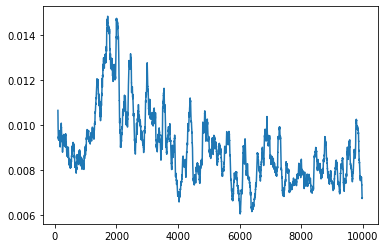

In [ ]:
import pandas as pd
df = pd.DataFrame(losses)
plt.plot(df.rolling(100).mean())

# 対局

## 対局プログラム

### グリーディー戦略プレイヤー

In [15]:
class GreedyPlayer:
    def __init__(self, model_path, device):
        self.device = device
        self.model = DQN().to(device)
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        self.features = np.empty((1, 2, 8, 8), np.float32)

    def go(self, board):
        with torch.no_grad():
            board.piece_planes(self.features[0])
            state = torch.from_numpy(self.features).to(self.device)
            q = self.model(state)
            # 合法手に絞る
            legal_moves = list(board.legal_moves)
            next_actions = torch.tensor([legal_moves], device=self.device, dtype=torch.long)
            legal_q = q.gather(1, next_actions)
            return legal_moves[legal_q.argmax(dim=1).item()]

### ランダムプレイヤー

In [16]:
class RandomPlayer:
    def go(self, board):
        legal_moves = board.legal_moves
        if len(legal_moves) == 0:
            return PASS
        else:
            return random.choice(list(legal_moves))

### 人間プレイヤー

In [17]:
RESIGN = -1
QUIT = -2

class HumanPlayer:
    def go(self, board):
        legal_moves = board.legal_moves
        if len(legal_moves) == 0:
            return PASS
        else:
            while True:
                move_str = input()
                if move_str == 'resign':
                    return RESIGN
                elif move_str == 'quit':
                    return QUIT
                try:
                    move = move_from_str(move_str)
                except:
                    print('invalid string')
                    continue
                if board.is_legal(move):
                    return move

### 対局プログラム

In [18]:
def main(player1, player2, model1='model.pt', model2=None, games=1, is_display=True):
    if is_display:
        try:
            is_jupyter = get_ipython().__class__.__name__ != 'TerminalInteractiveShell'
            if is_jupyter:
                from IPython.display import SVG, display
        except NameError:
            is_jupyter = False

    players = []
    for player, model in zip([player1, player2], [model1, model2]):
        if player == 'random':
            players.append(RandomPlayer())
        elif player == 'greedy':
            players.append(GreedyPlayer(model, device))
        elif player == 'human':
            players.append(HumanPlayer())
        else:
            raise RuntimeError(f'{player} not found')

    black_won_count = 0
    white_won_count = 0
    draw_count = 0
    board = Board()
    for n in range(games):
        print(f'game {n}')
        board.reset()
        move = None

        i = 0
        while not board.is_game_over():
            i += 1

            if is_display:
                print(f'{i}: ' + ('black' if board.turn == BLACK_TURN else 'white'))
                if is_jupyter:
                    display(SVG(board.to_svg(move)))
                else:
                    print(board)

            if board.puttable_num() == 0:
                move = PASS
            else:
                player = players[(i - 1) % 2]
                move = player.go(board)
                if isinstance(player, HumanPlayer):
                    if move == RESIGN:
                        break
                    elif move == QUIT:
                        return
                assert board.is_legal(move)

            if is_display:
                print(move_to_str(move))

            board.move(move)

        if isinstance(player, HumanPlayer) and move == RESIGN:
            if board.turn == BLACK_TURN:
                print('white won')
                white_won_count += 1
            else:
                print('black won')
                black_won_count += 1
            continue

        if is_display:
            if is_jupyter:
                display(SVG(board.to_svg(move)))
            else:
                print(board)

        if board.turn == BLACK_TURN:
            piece_nums = [board.piece_num(), board.opponent_piece_num()]
        else:
            piece_nums = [board.opponent_piece_num(), board.piece_num()]

        print(f'result black={piece_nums[0]} white={piece_nums[1]}')
        if piece_nums[0] > piece_nums[1]:
            print('black won')
            black_won_count += 1
        elif piece_nums[1] > piece_nums[0]:
            print('white won')
            white_won_count += 1
        else:
            print('draw')
            draw_count += 1

    print(f'black:{black_won_count} white:{white_won_count} draw:{draw_count}')

## ランダムプレイヤーと対局

game 0
1: black


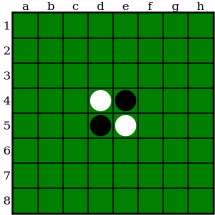

d3
2: white


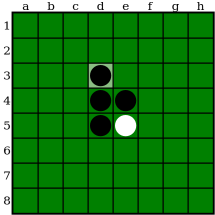

e3
3: black


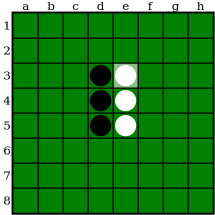

f4
4: white


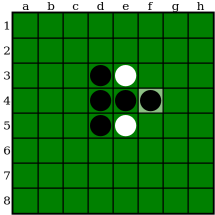

g3
5: black


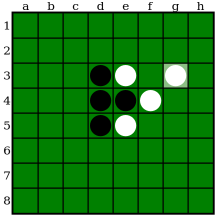

g4
6: white


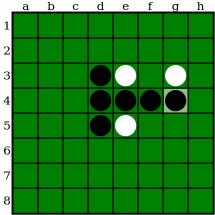

c5
7: black


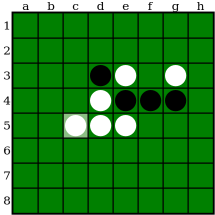

f3
8: white


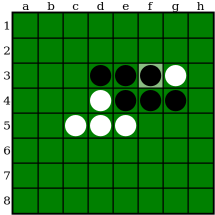

f2
9: black


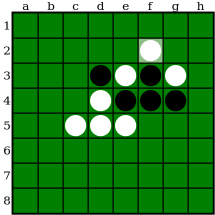

f1
10: white


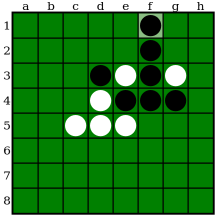

h4
11: black


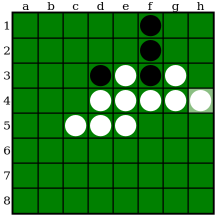

h3
12: white


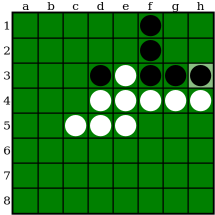

g1
13: black


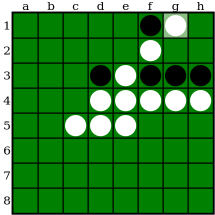

h1
14: white


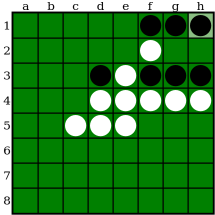

e2
15: black


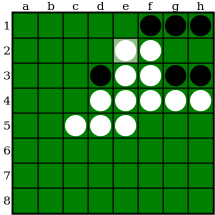

h5
16: white


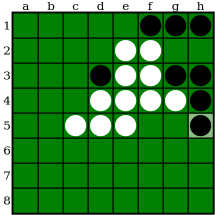

c2
17: black


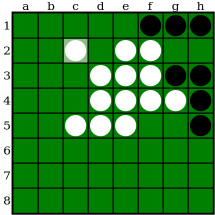

g5
18: white


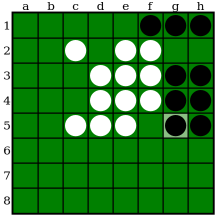

h6
19: black


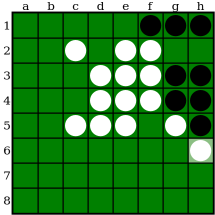

h7
20: white


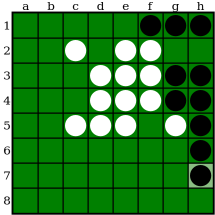

h2
21: black


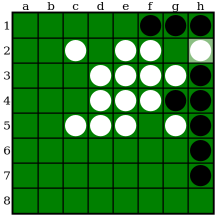

g2
22: white


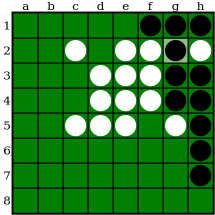

h8
23: black


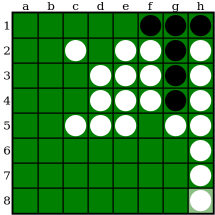

d2
24: white


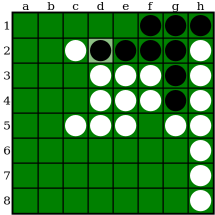

d1
25: black


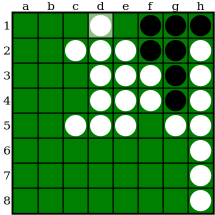

g6
26: white


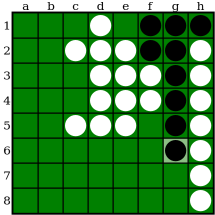

f5
27: black


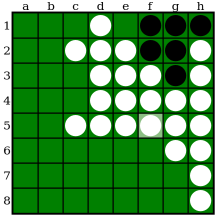

f6
28: white


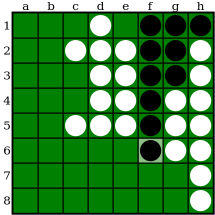

g7
29: black


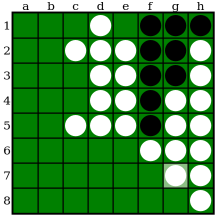

c3
30: white


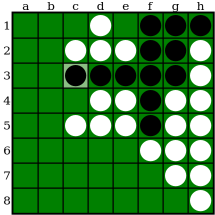

c4
31: black


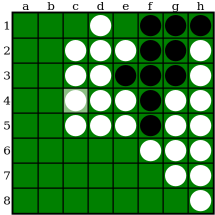

e1
32: white


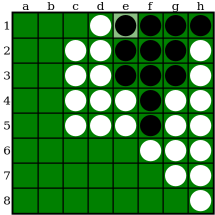

e6
33: black


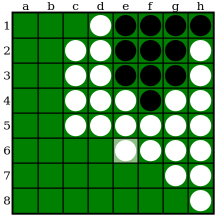

e7
34: white


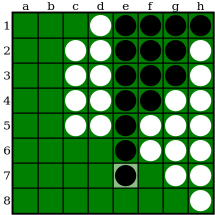

d7
35: black


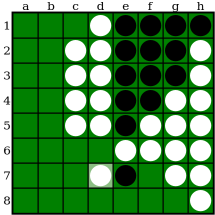

f7
36: white


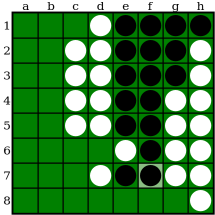

g8
37: black


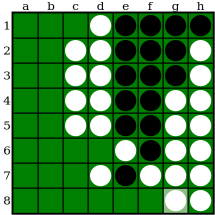

d6
38: white


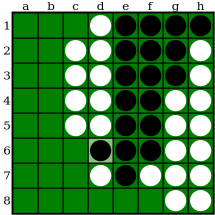

c7
39: black


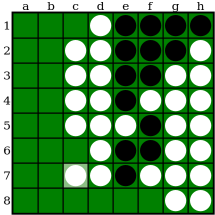

f8
40: white


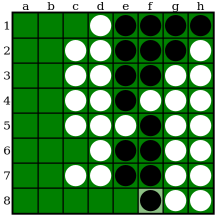

d8
41: black


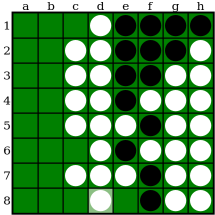

e8
42: white


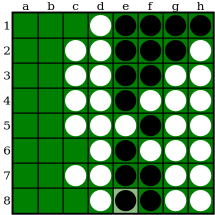

pass
43: black


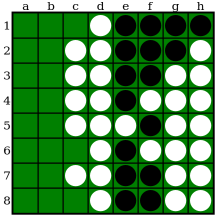

c6
44: white


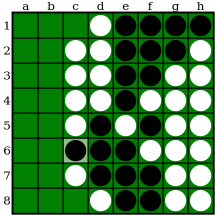

b6
45: black


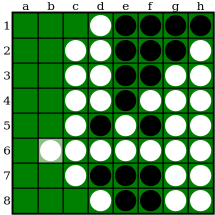

c8
46: white


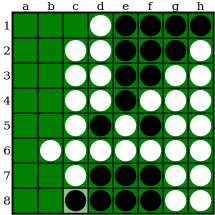

b8
47: black


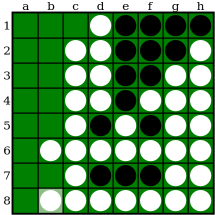

c1
48: white


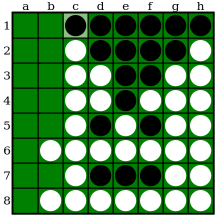

pass
49: black


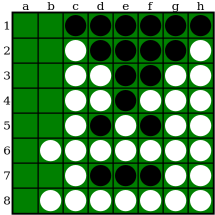

b1
50: white


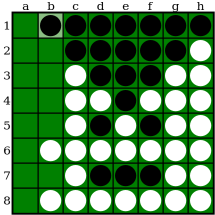

b2
51: black


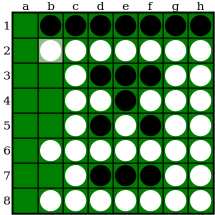

b4
52: white


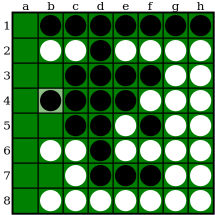

b5
53: black


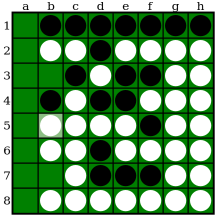

a1
54: white


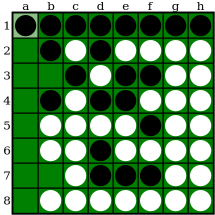

a2
55: black


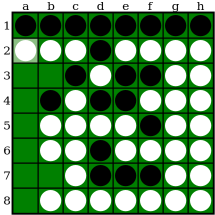

a3
56: white


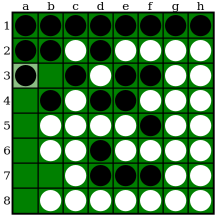

a4
57: black


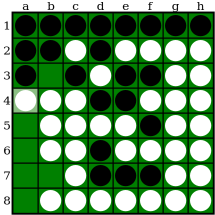

b3
58: white


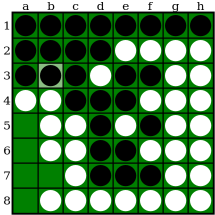

pass
59: black


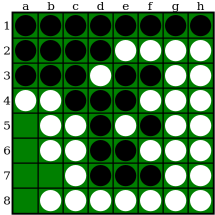

a5
60: white


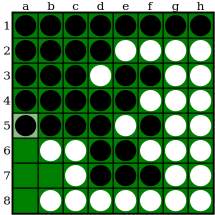

a6
61: black


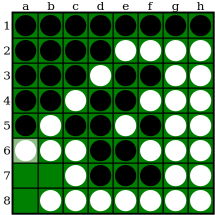

a7
62: white


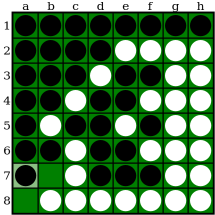

b7
63: black


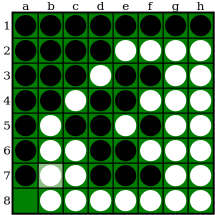

a8


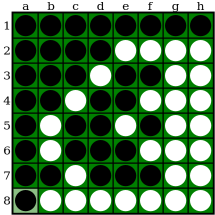

result black=35 white=29
black won
black:1 white:0 draw:0


In [19]:
main('greedy', 'random', model1='model.pt')

## ランダムプレイヤーと連続対局

In [22]:
main('greedy', 'random', model1='model.pt', games=1000, is_display=False)

game 0
result black=56 white=8
black won
game 1
result black=55 white=9
black won
game 2
result black=42 white=22
black won
game 3
result black=58 white=6
black won
game 4
result black=51 white=13
black won
game 5
result black=49 white=15
black won
game 6
result black=55 white=9
black won
game 7
result black=43 white=21
black won
game 8
result black=55 white=9
black won
game 9
result black=47 white=17
black won
game 10
result black=48 white=16
black won
game 11
result black=57 white=7
black won
game 12
result black=50 white=14
black won
game 13
result black=48 white=16
black won
game 14
result black=44 white=20
black won
game 15
result black=56 white=8
black won
game 16
result black=57 white=7
black won
game 17
result black=54 white=10
black won
game 18
result black=44 white=20
black won
game 19
result black=60 white=4
black won
game 20
result black=47 white=17
black won
game 21
result black=48 white=16
black won
game 22
result black=46 white=18
black won
game 23
result black=0 white=1

## 人間と対局

game 0
1: black


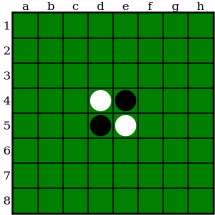

f5
2: white


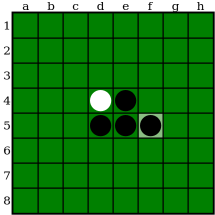

f4
f4
3: black


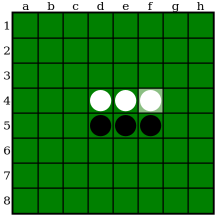

c3
4: white


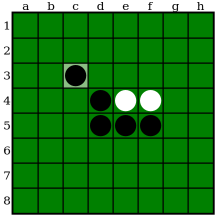

f6
f6
5: black


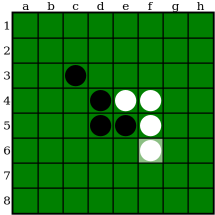

g5
6: white


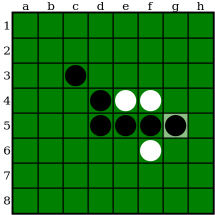

c6
c6
7: black


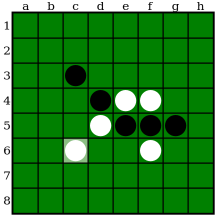

e3
8: white


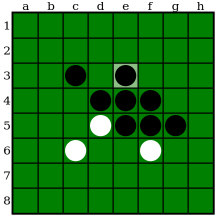

d3
d3
9: black


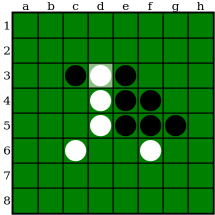

c2
10: white


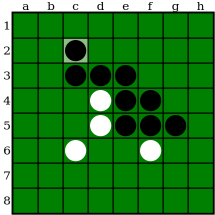

f3
f3
11: black


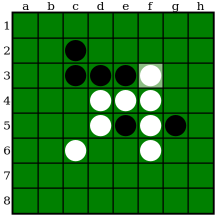

g3
12: white


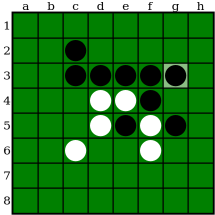

g4
g4
13: black


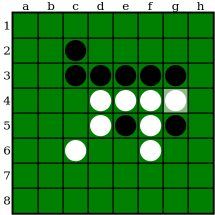

g6
14: white


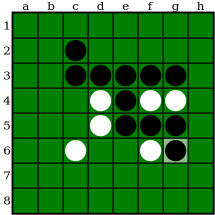

h6
h6
15: black


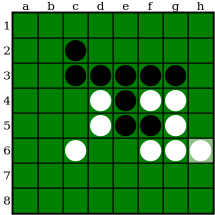

h3
16: white


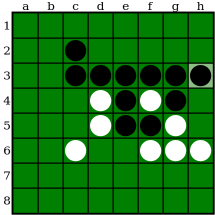

d6
d6
17: black


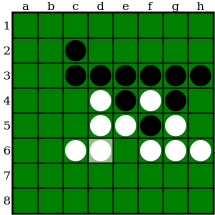

h5
18: white


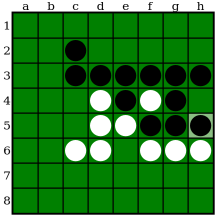

h4
h4
19: black


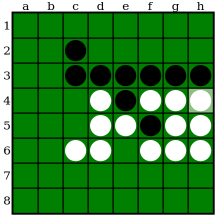

c5
20: white


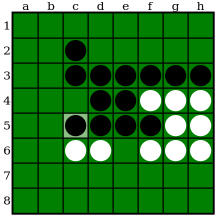

h2
h2
21: black


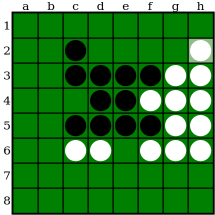

e7
22: white


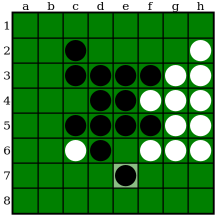

e6
e6
23: black


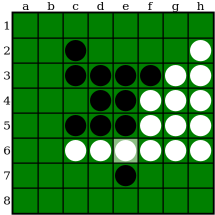

c7
24: white


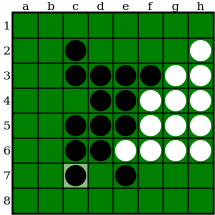

e8
e8
25: black


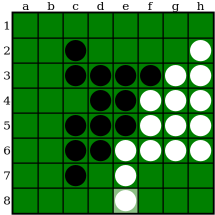

f8
26: white


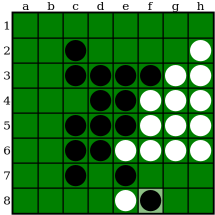

g8
g8
27: black


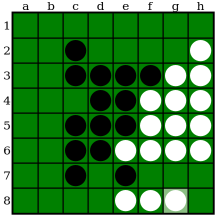

f7
28: white


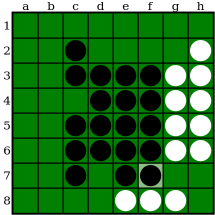

d8
d8
29: black


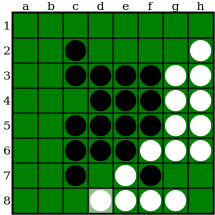

g7
30: white


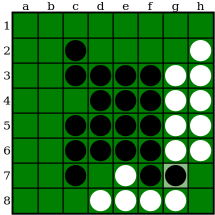

d7
d7
31: black


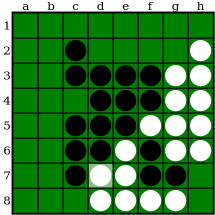

h7
32: white


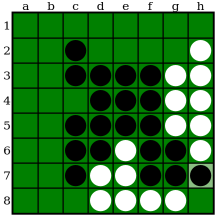

h8
h8
33: black


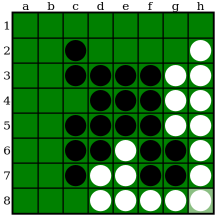

c8
34: white


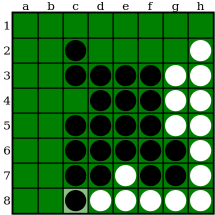

b8
b8
35: black


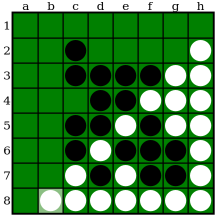

g2
36: white


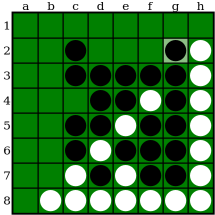

c4
c4
37: black


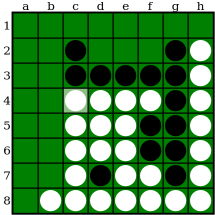

b4
38: white


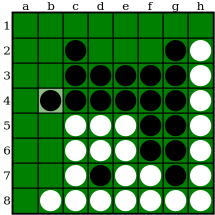

a4
a4
39: black


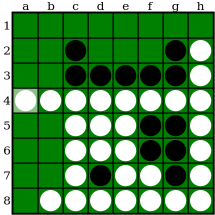

a5
40: white


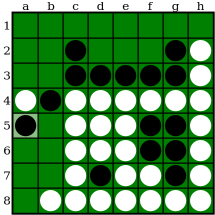

a6
a6
41: black


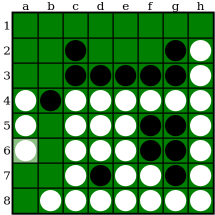

b6
42: white


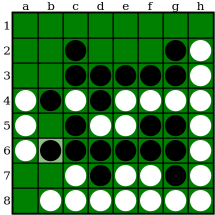

b5
b5
43: black


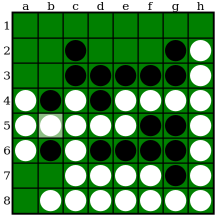

b7
44: white


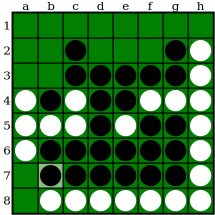

a8
d2
d2
45: black


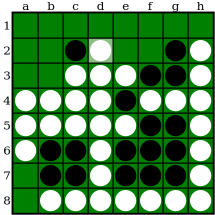

e2
46: white


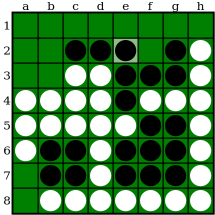

a8
a8
47: black


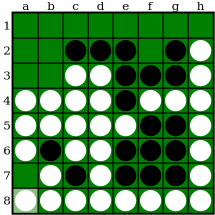

a7
48: white


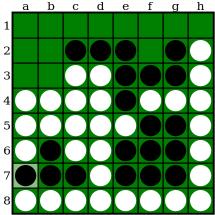

h1
h1
49: black


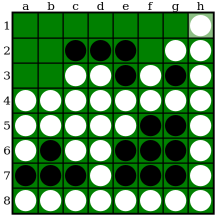

g1
50: white


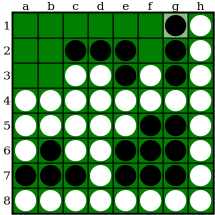

f1
f1
51: black


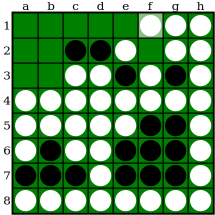

e1
52: white


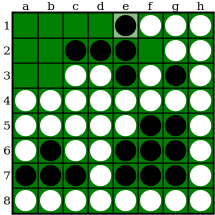

d1
d1
53: black


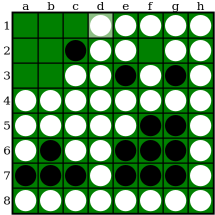

c1
54: white


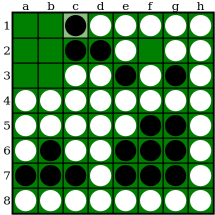

b1
b1
55: black


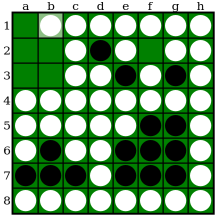

a3
56: white


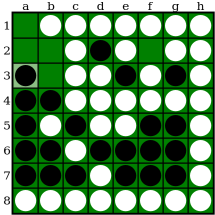

f2
f2
57: black


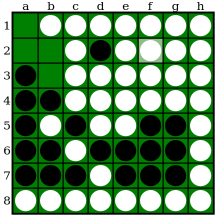

b3
58: white


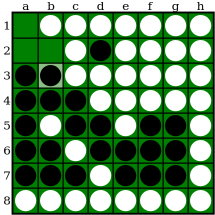

a2
a2
59: black


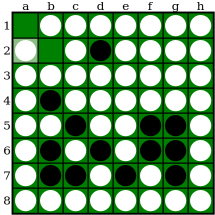

b2
60: white


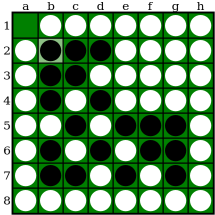

a1
a1


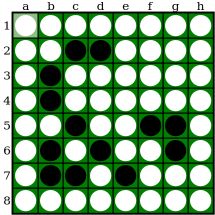

result black=13 white=51
white won
black:0 white:1 draw:0


In [ ]:
main('greedy', 'human', model1='model.pt')